In [1]:
import numpy as np
import math
import torch
from collections import defaultdict
import gym
import turtle
import numpy as np
import datetime
import argparse
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Define Algorithm

In [2]:
class QLearning(object):
    def __init__(self,n_states,
                 n_actions,cfg):
        self.n_actions = n_actions 
        self.lr = cfg.lr
        self.gamma = cfg.gamma  # discount
        self.epsilon = cfg.epsilon_start
        self.sample_count = 0  
        self.epsilon_start = cfg.epsilon_start
        self.epsilon_end = cfg.epsilon_end
        self.epsilon_decay = cfg.epsilon_decay
        self.Q_table  = defaultdict(lambda: np.zeros(n_actions))
    def sample_action(self, state):
        ''' action sampling, use it when training
        '''
        self.sample_count += 1
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.sample_count / self.epsilon_decay)  # epsilon decay
        # e-greedy
        if np.random.uniform(0, 1) > self.epsilon:
            action = np.argmax(self.Q_table[str(state)]) 
        else:
            action = np.random.choice(self.n_actions)
        return action
    def predict_action(self,state):
        ''' action choosing, use it when testing
        '''
        action = np.argmax(self.Q_table[str(state)])
        return action
    def update(self, state, action, reward, next_state, terminated):
        Q_predict = self.Q_table[str(state)][action] 
        if terminated:
            Q_target = reward  
        else:
            Q_target = reward + self.gamma * np.max(self.Q_table[str(next_state)]) 
        self.Q_table[str(state)][action] += self.lr * (Q_target - Q_predict)

## 2. Define Training Process

In [3]:
def train(cfg,env,agent):
    print('start training！')
    print(f'environment:{cfg.env_name}, algorithm:{cfg.algo_name}, device:{cfg.device}')
    rewards = []  
    for i_ep in range(cfg.train_eps):
        ep_reward = 0  
        state = env.reset(seed=cfg.seed)  
        while True:
            action = agent.sample_action(state) 
            next_state, reward, terminated, info = env.step(action) 
            agent.update(state, action, reward, next_state, terminated)
            state = next_state
            ep_reward += reward
            if terminated:
                break
        rewards.append(ep_reward)
        if (i_ep+1)%20==0:
            print(f"epoch：{i_ep+1}/{cfg.train_eps}，reward：{ep_reward:.1f}，Epsilon：{agent.epsilon:.3f}")
    print('end training！')
    return {"rewards":rewards}

def test(cfg,env,agent):
    print('start testing！')
    print(f'environment：{cfg.env_name}, algorithm：{cfg.algo_name}, device：{cfg.device}')
    rewards = []  
    for i_ep in range(cfg.test_eps):
        ep_reward = 0  
        state = env.reset(seed=cfg.seed) 
        while True:
            action = agent.predict_action(state) 
            next_state, reward, terminated, info = env.step(action) 
            state = next_state 
            ep_reward += reward
            if terminated:
                break
        rewards.append(ep_reward)
        print(f"epoch：{i_ep+1}/{cfg.test_eps}, reward：{ep_reward:.1f}")
    print('end testing！')
    return {"rewards":rewards}

## 3. Define Environment

In [6]:
class CliffWalkingWapper(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.t = None
        self.unit = 50
        self.max_x = 12
        self.max_y = 4

    def draw_x_line(self, y, x0, x1, color='gray'):
        assert x1 > x0
        self.t.color(color)
        self.t.setheading(0)
        self.t.up()
        self.t.goto(x0, y)
        self.t.down()
        self.t.forward(x1 - x0)

    def draw_y_line(self, x, y0, y1, color='gray'):
        assert y1 > y0
        self.t.color(color)
        self.t.setheading(90)
        self.t.up()
        self.t.goto(x, y0)
        self.t.down()
        self.t.forward(y1 - y0)

    def draw_box(self, x, y, fillcolor='', line_color='gray'):
        self.t.up()
        self.t.goto(x * self.unit, y * self.unit)
        self.t.color(line_color)
        self.t.fillcolor(fillcolor)
        self.t.setheading(90)
        self.t.down()
        self.t.begin_fill()
        for i in range(4):
            self.t.forward(self.unit)
            self.t.right(90)
        self.t.end_fill()

    def move_player(self, x, y):
        self.t.up()
        self.t.setheading(90)
        self.t.fillcolor('red')
        self.t.goto((x + 0.5) * self.unit, (y + 0.5) * self.unit)

    def render(self):
        if self.t == None:
            self.t = turtle.Turtle()
            self.wn = turtle.Screen()
            self.wn.setup(self.unit * self.max_x + 100,
                          self.unit * self.max_y + 100)
            self.wn.setworldcoordinates(0, 0, self.unit * self.max_x,
                                        self.unit * self.max_y)
            self.t.shape('circle')
            self.t.width(2)
            self.t.speed(0)
            self.t.color('gray')
            for _ in range(2):
                self.t.forward(self.max_x * self.unit)
                self.t.left(90)
                self.t.forward(self.max_y * self.unit)
                self.t.left(90)
            for i in range(1, self.max_y):
                self.draw_x_line(
                    y=i * self.unit, x0=0, x1=self.max_x * self.unit)
            for i in range(1, self.max_x):
                self.draw_y_line(
                    x=i * self.unit, y0=0, y1=self.max_y * self.unit)

            for i in range(1, self.max_x - 1):
                self.draw_box(i, 0, 'black')
            self.draw_box(self.max_x - 1, 0, 'yellow')
            self.t.shape('turtle')

        x_pos = self.s % self.max_x
        y_pos = self.max_y - 1 - int(self.s / self.max_x)
        self.move_player(x_pos, y_pos)

In [5]:
def env_agent_config(cfg,seed=1):
    '''environment and agent
    '''    
    env = gym.make(cfg.env_name,new_step_api=True)  
    env = CliffWalkingWapper(env)
    n_states = env.observation_space.n 
    n_actions = env.action_space.n 
    agent = QLearning(n_states,n_actions,cfg)
    return env,agent

## 4. Set Parameter

In [9]:
class Config:
    def __init__(self):
        self.env_name = 'CliffWalking-v0' 
        self.algo_name = 'Q-Learning' 
        self.train_eps = 500 # epoches
        self.test_eps = 20 
        self.max_steps = 200 
        self.epsilon_start = 0.95  #  e-greedy
        self.epsilon_end = 0.01 
        self.epsilon_decay = 300 
        self.gamma = 0.9 # discount
        self.lr = 0.1 
        self.seed = 1
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
        else:
            self.device = torch.device('cpu')

def smooth(data, weight=0.9):  
    last = data[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point 
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,title="learning curve"):
    sns.set()
    plt.figure()  
    plt.title(f"{title}")
    plt.xlim(0, len(rewards), 10)  
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()

## 5. Start Training

start training！
environment:CliffWalking-v0, algorithm:Q-Learning, device:cuda
epoch：20/500，reward：-314.0，Epsilon：0.010
epoch：40/500，reward：-58.0，Epsilon：0.010
epoch：60/500，reward：-28.0，Epsilon：0.010
epoch：80/500，reward：-61.0，Epsilon：0.010
epoch：100/500，reward：-24.0，Epsilon：0.010
epoch：120/500，reward：-31.0，Epsilon：0.010
epoch：140/500，reward：-35.0，Epsilon：0.010
epoch：160/500，reward：-39.0，Epsilon：0.010
epoch：180/500，reward：-37.0，Epsilon：0.010
epoch：200/500，reward：-26.0，Epsilon：0.010
epoch：220/500，reward：-17.0，Epsilon：0.010
epoch：240/500，reward：-19.0，Epsilon：0.010
epoch：260/500，reward：-13.0，Epsilon：0.010
epoch：280/500，reward：-17.0，Epsilon：0.010
epoch：300/500，reward：-13.0，Epsilon：0.010
epoch：320/500，reward：-13.0，Epsilon：0.010
epoch：340/500，reward：-13.0，Epsilon：0.010
epoch：360/500，reward：-13.0，Epsilon：0.010
epoch：380/500，reward：-13.0，Epsilon：0.010
epoch：400/500，reward：-13.0，Epsilon：0.010
epoch：420/500，reward：-13.0，Epsilon：0.010
epoch：440/500，reward：-13.0，Epsilon：0.010
epoch：460/500，reward：-

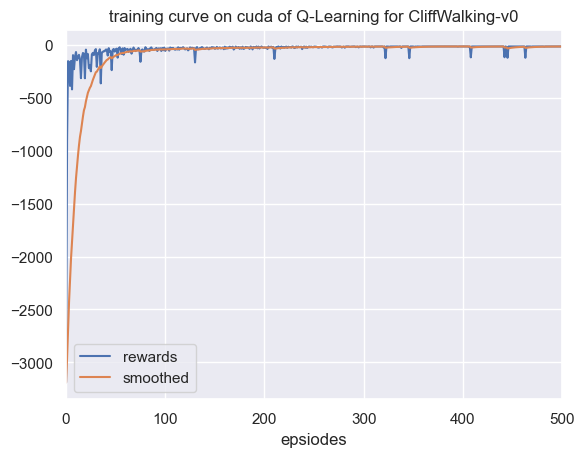

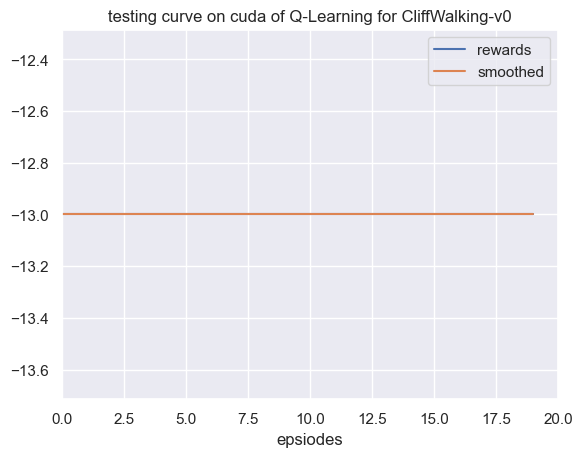

In [10]:
cfg = Config() 

env, agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)
 
plot_rewards(res_dic['rewards'], title=f"training curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")  
res_dic = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], title=f"testing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}") 